In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:
# read offense data
offense = pd.read_csv('data/offense.csv')
# read defense data
defense = pd.read_csv('data/defense.csv')
# read salary data
salary = pd.read_csv('data/salary.csv', index_col=0)
# change columns (uppercase first letter) to match the other data
salary.columns = ['Team', 'Year'] + list(salary.columns[2:])
# read standings data
standings = pd.read_csv('data/standings.csv')

Need to fix the offense and defense stats so that they are the previous year. Can do this by adding 1 to the year before merging the datasets. Salary is known at the beginning of the season so the year doesn't have to change.

In [3]:
offense['Year'] += 1
defense['Year'] += 1

In [4]:
# merge the offense and defense data with suffixes
combined = pd.merge(offense, defense, on=['Team', 'Year'], suffixes=('_off', '_def'))
# merge the salary data
combined = pd.merge(combined, salary, on=['Team', 'Year'])
# merge the standings dataframe - use left so 2018 data stays
combined = pd.merge(combined, standings, on=['Team', 'Year'], how='left')

In [5]:
# split out the X and y from combined
X_all = combined[combined.columns[:-8]].copy()
y_all = combined[combined.columns[-8:]].copy()

# add team and year back into y
y_all.insert(0, 'Team', X_all['Team'])
y_all.insert(1, 'Year', X_all['Year'])

In [106]:
target_var = 'Playoffs'

In [134]:
data = X_all.merge(y_all[['Team', 'Year', target_var]])

data_future = data[data['Year'] == 2018]

data = data[data['Year'] < 2018]

features = data.columns[2:-1]

In [130]:
data[target_var].value_counts()

0.0000    100
1.0000     60
Name: Playoffs, dtype: int64

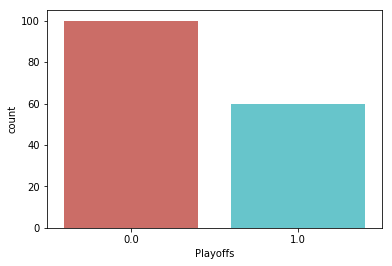

In [131]:
_ = sns.countplot(x='Playoffs', data=data, palette='hls')

In [132]:
data.groupby('Playoffs').mean().T

Playoffs,0.0,1.0
Year,2015.0000,2015.0000
Yds/G_rush_off,109.8120,114.5217
TD_rush_off,12.0400,13.2500
Yds/G_pass_off,234.5430,243.2283
Pct_off,61.5260,63.0617
TD_pass_off,23.8000,26.9333
Sck_off,37.8900,36.5333
Rate_off,85.8630,91.5483
Pts/G_off,21.9560,24.3833
Pen Yds_off,891.6300,888.6667


## Logistic Regression

#### Start with a baseline model

In [136]:
X = data[features]
y = data[target_var]

In [138]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [143]:
X_valid = X[data['Year'] == 2017]
y_valid = y[data['Year'] == 2017]

In [148]:
X_train, X_test, y_train, y_test = \
    train_test_split(X[data['Year'] < 2017], y[data['Year'] < 2017], test_size=0.3)

In [ ]:
sm = SMOTE(ratio=1.0, random_state=42)
